<a href="https://colab.research.google.com/github/sait1801/grid-test-cases/blob/main/ren_rate_dnn_cons_sorunlu_bak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [191]:
import pandas as pd
import requests

In [192]:
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [193]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('consum_3years').sheet1
test_sheet = gc.open('consume_real_test_updated').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
rows_test = test_sheet.get_all_values()

print(rows)

# Convert to a DataFrame and render.
data = pd.DataFrame.from_records(rows)
test_data = pd.DataFrame.from_records(rows_test)

[['Date', 'Hour', 'Consumption'], ['01.01.2022', '0:00', '31.021,25'], ['01.01.2022', '1:00', '29.710,69'], ['01.01.2022', '2:00', '28.318,53'], ['01.01.2022', '3:00', '27.169,55'], ['01.01.2022', '4:00', '26.525,16'], ['01.01.2022', '5:00', '26.319,80'], ['01.01.2022', '6:00', '26.809,64'], ['01.01.2022', '7:00', '26.969,94'], ['01.01.2022', '8:00', '27.592,75'], ['01.01.2022', '9:00', '29.365,83'], ['01.01.2022', '10:00', '31.016,83'], ['01.01.2022', '11:00', '32.843,03'], ['01.01.2022', '12:00', '33.557,93'], ['01.01.2022', '13:00', '33.795,67'], ['01.01.2022', '14:00', '33.586,58'], ['01.01.2022', '15:00', '33.220,55'], ['01.01.2022', '16:00', '33.558,85'], ['01.01.2022', '17:00', '35.121,94'], ['01.01.2022', '18:00', '36.687,64'], ['01.01.2022', '19:00', '36.206,53'], ['01.01.2022', '20:00', '35.282,80'], ['01.01.2022', '21:00', '34.354,39'], ['01.01.2022', '22:00', '33.503,32'], ['01.01.2022', '23:00', '31.717,84'], ['02.01.2022', '0:00', '30.615,75'], ['02.01.2022', '1:00', '29.

In [194]:
data.columns = ['Date'	,'Hour'	,'Consumption']
data= data.drop(0)

test_data.columns = ['Date'	,'Hour'	,'Consumption']
test_data= test_data.drop(0)
test_data.tail(5)

,Date,Hour,Consumption
2389,08.01.2024,12:00,"40.718,66"
2390,08.01.2024,13:00,"41.461,93"
2391,08.01.2024,14:00,"42.092,04"
2392,08.01.2024,15:00,"41.660,61"
2393,08.01.2024,16:00,"40.515,80"


In [195]:
df=data.copy()
df.shape

(13872, 3)

##Adding WeekDay parameter to dataframe. The consumption may change daily due to weekin-weekend realtion

In [196]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Weekday'] = 0

In [197]:
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(len(df)):
  row = df.iloc[i]
  weekday = row['Date'].dayofweek
  df.loc[i, 'Weekday'] = weekday


In [198]:
df.tail(5)

,Date,Hour,Consumption,Weekday
13869,2023-08-01,20:00,"48.395,28",1.0
13870,2023-08-01,21:00,"47.683,05",1.0
13871,2023-08-01,22:00,"46.370,95",1.0
13872,2023-08-01,23:00,"43.560,02",0.0
0,NaT,NaN,NaN,5.0


##Changing the format of the energy to MGW

In [199]:
def convert_consumption(consumption):
  """Converts a string consumption to a float."""
  consumption = str(consumption).replace(',', '')
  return float(consumption)

In [200]:
df['Consumption'] = df['Consumption'].apply(convert_consumption)

##Add seasons and weekin-weekday parameters

In [201]:
df['Week_tag'] = 0
for i in range(len(df)):
  row = df.iloc[i]
  weekday = row['Weekday']
  if weekday in ['Sunday', 'Saturday']:
    df.loc[i, 'Week_tag'] = 1 #weekedn
  else:
    df.loc[i, 'Week_tag'] = 0 #weekin



In [202]:
# Assuming your DataFrame is named 'df'
df = df.dropna(subset=['Date'])

# Reset the index after removing the row
df.reset_index(drop=True, inplace=True)
df.tail(5)

,Date,Hour,Consumption,Weekday,Week_tag
13867,2023-08-01,19:00,46.94286,1.0,0
13868,2023-08-01,20:00,48.39528,1.0,0
13869,2023-08-01,21:00,47.68305,1.0,0
13870,2023-08-01,22:00,46.37095,1.0,0
13871,2023-08-01,23:00,43.56002,0.0,0


##Previous Consumption Data Adding

In [203]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df_sample =df.copy()


def convert_hour(hour):
  hour = str(hour)
  """Converts a time string in H:MM format to HH:MM format."""
  if len(hour) == 4:
    hour = '0' + hour[0]
  return hour

df_sample['Hour'] = df_sample['Hour'].apply(convert_hour)
print(df_sample['Hour'])
df_sample['Hour'] = df_sample['Hour'].str[:2].astype('int')

for i in range(1, 6):
    df_sample['previous-{}'.format(i)] = df_sample['Consumption'].shift(i)
for i in range(1, 6):
    df_sample['previous-{}'.format(i)].fillna(df_sample['Consumption'], inplace=True)


0           00
1           01
2           02
3           03
4           04
         ...  
13867    19:00
13868    20:00
13869    21:00
13870    22:00
13871    23:00
Name: Hour, Length: 13872, dtype: object


In [204]:
df_sample.head(6)


,Date,Hour,Consumption,Weekday,Week_tag,previous-1,previous-2,previous-3,previous-4,previous-5
0,2022-01-01,0,31.02125,5.0,0,31.02125,31.02125,31.02125,31.02125,31.02125
1,2022-01-01,1,29.71069,5.0,0,31.02125,29.71069,29.71069,29.71069,29.71069
2,2022-01-01,2,28.31853,5.0,0,29.71069,31.02125,28.31853,28.31853,28.31853
3,2022-01-01,3,27.16955,5.0,0,28.31853,29.71069,31.02125,27.16955,27.16955
4,2022-01-01,4,26.52516,5.0,0,27.16955,28.31853,29.71069,31.02125,26.52516
5,2022-01-01,5,26.31980,5.0,0,26.52516,27.16955,28.31853,29.71069,31.02125


In [205]:
df_sample= df_sample.iloc[5:,:]
df_sample.head(10)

,Date,Hour,Consumption,Weekday,Week_tag,previous-1,previous-2,previous-3,previous-4,previous-5
5,2022-01-01,5,26.31980,5.0,0,26.52516,27.16955,28.31853,29.71069,31.02125
6,2022-01-01,6,26.80964,5.0,0,26.31980,26.52516,27.16955,28.31853,29.71069
7,2022-01-01,7,26.96994,5.0,0,26.80964,26.31980,26.52516,27.16955,28.31853
8,2022-01-01,8,27.59275,5.0,0,26.96994,26.80964,26.31980,26.52516,27.16955
9,2022-01-01,9,29.36583,5.0,0,27.59275,26.96994,26.80964,26.31980,26.52516
10,2022-01-01,10,31.01683,5.0,0,29.36583,27.59275,26.96994,26.80964,26.31980
11,2022-01-01,11,32.84303,5.0,0,31.01683,29.36583,27.59275,26.96994,26.80964
12,2022-01-01,12,33.55793,5.0,0,32.84303,31.01683,29.36583,27.59275,26.96994
13,2022-01-01,13,33.79567,5.0,0,33.55793,32.84303,31.01683,29.36583,27.59275
14,2022-01-01,14,33.58658,5.0,0,33.79567,33.55793,32.84303,31.01683,29.36583


In [206]:
df_sample.dtypes

Date           datetime64[ns]
Hour                    int64
Consumption           float64
Weekday               float64
Week_tag                int64
previous-1            float64
previous-2            float64
previous-3            float64
previous-4            float64
previous-5            float64
dtype: object

##Train DNN

In [207]:
df_sample.head(5)

,Date,Hour,Consumption,Weekday,Week_tag,previous-1,previous-2,previous-3,previous-4,previous-5
5,2022-01-01,5,26.31980,5.0,0,26.52516,27.16955,28.31853,29.71069,31.02125
6,2022-01-01,6,26.80964,5.0,0,26.31980,26.52516,27.16955,28.31853,29.71069
7,2022-01-01,7,26.96994,5.0,0,26.80964,26.31980,26.52516,27.16955,28.31853
8,2022-01-01,8,27.59275,5.0,0,26.96994,26.80964,26.31980,26.52516,27.16955
9,2022-01-01,9,29.36583,5.0,0,27.59275,26.96994,26.80964,26.31980,26.52516


In [208]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler  # Adapt for your scaler


# Preprocess data (adjust based on your specific requirements)
X = df_sample.drop(columns=['Date', 'Consumption'])  # Exclude target variable #The target will be hour or stg ?  'Date', 'Consumption', 'Hour'
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(X)

# Reshape data for LSTM input
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # Assuming a single timestep

Y = df_sample[['Consumption']]
Y_scaled = scaler_y.fit_transform(Y)

# Reshape data for LSTM input
Y_reshaped = Y_scaled.reshape((Y_scaled.shape[0], 1, Y_scaled.shape[1]))  # Assuming a single timestep

# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))  # Single unit for regression output


In [209]:
X.head(5)

,Hour,Weekday,Week_tag,previous-1,previous-2,previous-3,previous-4,previous-5
5,5,5.0,0,26.52516,27.16955,28.31853,29.71069,31.02125
6,6,5.0,0,26.31980,26.52516,27.16955,28.31853,29.71069
7,7,5.0,0,26.80964,26.31980,26.52516,27.16955,28.31853
8,8,5.0,0,26.96994,26.80964,26.31980,26.52516,27.16955
9,9,5.0,0,27.59275,26.96994,26.80964,26.31980,26.52516


In [210]:
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

In [211]:
from tensorflow.keras.callbacks import EarlyStopping
# Split data into training and testing sets (add validation set if desired)
train_size = int(0.8 * len(X_reshaped))  # Adjust split ratio as needed
X_train, X_test = X_reshaped[:train_size], X_reshaped[train_size:]
y_train, y_test = Y_reshaped[:train_size], Y_reshaped[train_size:]


early_stopping = EarlyStopping(
    monitor='val_loss',  # Adjust based on your chosen metric
    patience=10,  # Adapt patience to your training requirements
    min_delta=0.001,  # Define the minimum improvement threshold
    restore_best_weights=True  # Choose whether to restore best weights
)


# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
# model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate performance on test set
predictions = model.predict(X_test)


Epoch 1/100
347/347 [==============================] - 6s 8ms/step - loss: 0.1679 - val_loss: 0.0578
Epoch 2/100
347/347 [==============================] - 2s 7ms/step - loss: 0.0301 - val_loss: 0.0371
Epoch 3/100
347/347 [==============================] - 3s 8ms/step - loss: 0.0254 - val_loss: 0.0316
Epoch 4/100
347/347 [==============================] - 2s 6ms/step - loss: 0.0237 - val_loss: 0.0310
Epoch 5/100
347/347 [==============================] - 2s 6ms/step - loss: 0.0227 - val_loss: 0.0287
Epoch 6/100
347/347 [==============================] - 2s 6ms/step - loss: 0.0213 - val_loss: 0.0266
Epoch 7/100
347/347 [==============================] - 2s 6ms/step - loss: 0.0208 - val_loss: 0.0278
Epoch 8/100
347/347 [==============================] - 3s 8ms/step - loss: 0.0202 - val_loss: 0.0287
Epoch 9/100
347/347 [==============================] - 2s 7ms/step - loss: 0.0196 - val_loss: 0.0255
Epoch 10/100
347/347 [==============================] - 2s 6ms/step - loss: 0.0190 - val_lo

In [212]:
print(y_test.shape)
y_test = y_test.reshape((2774, 1))
print(predictions.shape)

mse = mean_squared_error(y_test, predictions)
print('MSE:', mse)

(2774, 1, 1)
(2774, 1)
MSE: 0.010643261751050072


In [213]:
# Create the DataFrame
df_kiyas = pd.DataFrame({'y_test': y_test.flatten(), 'predictions': predictions.flatten()})

In [214]:
df_kiyas.head(10)

,y_test,predictions
0,-0.153629,-0.172704
1,0.014009,0.086227
2,-0.115666,-0.047175
3,-0.079670,-0.179279
4,-0.075500,-0.097162
5,-0.179398,-0.069391
6,-0.204537,-0.127640
7,-0.231543,-0.151391
8,-0.006459,-0.196211
9,-0.036429,0.077533


In [215]:
y_test_original = scaler_y.inverse_transform(y_test)
predictions_original = scaler_y.inverse_transform(predictions)

In [216]:
import plotly.graph_objects as go

# Assuming 'df' is your DataFrame
fig = go.Figure()
columns = ['y_original', 'predict_original']
df_kiyas['y_original'] = y_test_original
df_kiyas['predict_original'] = predictions_original



In [217]:
# Add a trace for each column
for col in columns:
    fig.add_trace(go.Scatter(x=df_kiyas.index, y=df_kiyas[col], mode='lines', name=col))

fig.show()


In [218]:
df[train_size:].head(5)

,Date,Hour,Consumption,Weekday,Week_tag
11093,2023-04-08,5:00,31.41973,5.0,0
11094,2023-04-08,6:00,29.50944,5.0,0
11095,2023-04-08,7:00,29.22347,5.0,0
11096,2023-04-08,8:00,32.22292,5.0,0
11097,2023-04-08,9:00,33.96467,5.0,0


In [219]:
y_test_original

array([[35.79573],
       [36.73851],
       [36.00923],
       ...,
       [47.68305],
       [46.37095],
       [43.56002]])

DNN Trained ABove, now try on a new random data

##Validation test from a csv file

In [220]:
X.head(5)

,Hour,Weekday,Week_tag,previous-1,previous-2,previous-3,previous-4,previous-5
5,5,5.0,0,26.52516,27.16955,28.31853,29.71069,31.02125
6,6,5.0,0,26.31980,26.52516,27.16955,28.31853,29.71069
7,7,5.0,0,26.80964,26.31980,26.52516,27.16955,28.31853
8,8,5.0,0,26.96994,26.80964,26.31980,26.52516,27.16955
9,9,5.0,0,27.59275,26.96994,26.80964,26.31980,26.52516


In [221]:
# df_test = pd.read_csv('/content/consum.csv')
# df_nanay = pd.read_csv('/content/consum_sorun.csv')
# print(f"shapes : {df_test.shape}, {df_nanay}")

shapes : (4368, 3),             Date   Hour Consumption
0     01.01.2023  00:00   28.836,10
1     01.01.2023  01:00   27.608,62
2     01.01.2023  02:00   26.347,75
3     01.01.2023  03:00   25.243,18
4     01.01.2023  04:00   24.654,99
...          ...    ...         ...
4363  01.07.2023  19:00   32.039,67
4364  01.07.2023  20:00   33.599,51
4365  01.07.2023  21:00   34.059,46
4366  01.07.2023  22:00   32.945,67
4367  01.07.2023  23:00   31.673,21

[4368 rows x 3 columns]


In [222]:
# df_test = pd.read_csv('/content/consum_test.csv')
df_test = test_data

def add_previous_consumption(df):
  for i in range(1, 6):
      df['previous-{}'.format(i)] = df['Consumption'].shift(i)
  for i in range(1, 6):
      df['previous-{}'.format(i)].fillna(df_test['Consumption'], inplace=True)

add_previous_consumption(df_test)


#Convert Hour
df_test['Hour'] = df_test['Hour'].apply(convert_hour)

df_test['Hour'] = df_test['Hour'].str[:2].astype('int')
#COnvert consumption
df_test['Consumption'] = df_test['Consumption'].apply(convert_consumption)

#convert kgup and previous data
columns_kgup = ['Consumption','previous-1','previous-2','previous-3','previous-4','previous-5']

for cols in columns_kgup:
  df_test[cols] = df_test[cols].apply(convert_consumption)



print(df_test.shape)
df_test.head(6)



(2393, 8)


,Date,Hour,Consumption,previous-1,previous-2,previous-3,previous-4,previous-5
1,01.10.2023,0,32.10000,32.10000,32.10000,32.10000,32.10000,32.10000
2,01.10.2023,1,30.71240,32.10000,30.71240,30.71240,30.71240,30.71240
3,01.10.2023,2,29.64682,30.71240,32.10000,29.64682,29.64682,29.64682
4,01.10.2023,3,28.72400,29.64682,30.71240,32.10000,28.72400,28.72400
5,01.10.2023,4,28.37323,28.72400,29.64682,30.71240,32.10000,28.37323
6,01.10.2023,5,28.23037,28.37323,28.72400,29.64682,30.71240,32.10000


In [223]:
# df_test= test_data
df_test.head(6)


,Date,Hour,Consumption,previous-1,previous-2,previous-3,previous-4,previous-5
1,01.10.2023,0,32.10000,32.10000,32.10000,32.10000,32.10000,32.10000
2,01.10.2023,1,30.71240,32.10000,30.71240,30.71240,30.71240,30.71240
3,01.10.2023,2,29.64682,30.71240,32.10000,29.64682,29.64682,29.64682
4,01.10.2023,3,28.72400,29.64682,30.71240,32.10000,28.72400,28.72400
5,01.10.2023,4,28.37323,28.72400,29.64682,30.71240,32.10000,28.37323
6,01.10.2023,5,28.23037,28.37323,28.72400,29.64682,30.71240,32.10000


##Iterative appraoch

In [224]:
print(type(X_train))
df_test['Date'] = pd.to_datetime(df_test['Date'], dayfirst=True)
df_test['Weekday'] = 0

<class 'numpy.ndarray'>


In [225]:
df_test.head(30)

,Date,Hour,Consumption,previous-1,previous-2,previous-3,previous-4,previous-5,Weekday
1,2023-10-01,0,32.10000,32.10000,32.10000,32.10000,32.10000,32.10000,0
2,2023-10-01,1,30.71240,32.10000,30.71240,30.71240,30.71240,30.71240,0
3,2023-10-01,2,29.64682,30.71240,32.10000,29.64682,29.64682,29.64682,0
4,2023-10-01,3,28.72400,29.64682,30.71240,32.10000,28.72400,28.72400,0
5,2023-10-01,4,28.37323,28.72400,29.64682,30.71240,32.10000,28.37323,0
6,2023-10-01,5,28.23037,28.37323,28.72400,29.64682,30.71240,32.10000,0
7,2023-10-01,6,27.48021,28.23037,28.37323,28.72400,29.64682,30.71240,0
8,2023-10-01,7,26.23125,27.48021,28.23037,28.37323,28.72400,29.64682,0
9,2023-10-01,8,27.61650,26.23125,27.48021,28.23037,28.37323,28.72400,0
10,2023-10-01,9,29.45447,27.61650,26.23125,27.48021,28.23037,28.37323,0


In [226]:
 """add weekday to test data """
for i in range(len(df_test)):
  row = df_test.iloc[i]
  weekday = row['Date'].dayofweek
  df_test.loc[i, 'Weekday'] = weekday


In [227]:
df_test['Week_tag'] = 0
for i in range(len(df_test)):
  row = df_test.iloc[i]
  weekday = row['Weekday']
  if weekday in ['Sunday', 'Saturday']:
    df_test.loc[i, 'Week_tag'] = 1 #weekedn
  else:
    df_test.loc[i, 'Week_tag'] = 0 #weekin



In [228]:
df_test.head(5)

,Date,Hour,Consumption,previous-1,previous-2,previous-3,previous-4,previous-5,Weekday,Week_tag
1,2023-10-01,0.0,32.10000,32.10000,32.10000,32.10000,32.10000,32.10000,6.0,0
2,2023-10-01,1.0,30.71240,32.10000,30.71240,30.71240,30.71240,30.71240,6.0,0
3,2023-10-01,2.0,29.64682,30.71240,32.10000,29.64682,29.64682,29.64682,6.0,0
4,2023-10-01,3.0,28.72400,29.64682,30.71240,32.10000,28.72400,28.72400,6.0,0
5,2023-10-01,4.0,28.37323,28.72400,29.64682,30.71240,32.10000,28.37323,6.0,0


In [229]:
# Assuming your test data is in a DataFrame named 'test_data'
df_test = df_test[['Date','Hour','Consumption', 'Weekday', 'Week_tag', 'previous-1', 'previous-2', 'previous-3', 'previous-4', 'previous-5']]

df_test_X = df_test.drop(columns=['Date', 'Consumption'])
print(df_test_X.head(5))

df_test_Y = df_test[['Consumption']]

#transform the test data
# df_test_X = scaler_x.fit_transform(df_test_X) //todo : fittransofrm correct
df_test_X = scaler_x.transform(df_test_X)

# df_test_Y = scaler_y.fit_transform(df_test_Y)

#reshape them
# Reshape data for LSTM input
df_test_X = df_test_X.reshape((df_test_X.shape[0], 1, df_test_X.shape[1]))  # Assuming a single timestep
# df_test_Y = df_test_Y.reshape((df_test_Y.shape[0], 1, df_test_Y.shape[1]))  # Assuming a single timestep


   Hour  Weekday  Week_tag  previous-1  previous-2  previous-3  previous-4  \
1   0.0      6.0         0    32.10000    32.10000    32.10000    32.10000   
2   1.0      6.0         0    32.10000    30.71240    30.71240    30.71240   
3   2.0      6.0         0    30.71240    32.10000    29.64682    29.64682   
4   3.0      6.0         0    29.64682    30.71240    32.10000    28.72400   
5   4.0      6.0         0    28.72400    29.64682    30.71240    32.10000   

   previous-5  
1    32.10000  
2    30.71240  
3    29.64682  
4    28.72400  
5    28.37323  


In [230]:
pred_test = model.predict(df_test_X)

75/75 [==============================] - 0s 2ms/step


In [231]:
pred_test_real = scaler_y.inverse_transform(pred_test)

In [232]:
print(pred_test_real[:5])

[[30.128767]
 [30.72579 ]
 [27.55389 ]
 [27.92439 ]
 [27.771751]]


In [233]:
df_test_Y.head(5)

,Consumption
1,32.10000
2,30.71240
3,29.64682
4,28.72400
5,28.37323


In [234]:
df_test_Y['predictions'] = pred_test_real


<ipython-input-234-9bb77168a7e2>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [235]:
df_test_Y.head(2)

,Consumption,predictions
1,32.1000,30.128767
2,30.7124,30.725790


In [236]:
import numpy as np
df_new = pd.DataFrame()

df_new['error'] = df_test_Y['Consumption'] - df_test_Y['predictions']

inf_norm = np.max(np.abs(df_new['error']))
print(inf_norm)

3.561738717041017


##Plot the real life test result with really bad data

In [237]:
# Add a trace for each column
fig2 = go.Figure()

columns_test =  ['Consumption', 'predictions']
for col in columns_test:
    fig2.add_trace(go.Scatter(x=df_test_Y.index, y=df_test_Y[col], mode='lines', name=col))

fig2.show()


##IF Not Persuaded, Let's try with haredcoded example

The data is :


In [238]:
data = [[8,0,0,33.604,30.037,28.481,28.051,28.335],[9,0,0,38.677,33.604,30.037,28.481,28.051],[10,0,0,41.483,38.677,33.604,30.037,28.481], [11,0,0,42.140,41.483,38.677,33.604,30.037], [12,0,0,41.776,42.140,41.483,38.677,33.604]]
df_hard = pd.DataFrame(data, columns=['Hour', 'Weekday', 'Week_tag', 'previous-1', 'previous-2', 'previous-3', 'previous-4', 'previous-5'])
df_hard.head(5)

,Hour,Weekday,Week_tag,previous-1,previous-2,previous-3,previous-4,previous-5
0,8,0,0,33.604,30.037,28.481,28.051,28.335
1,9,0,0,38.677,33.604,30.037,28.481,28.051
2,10,0,0,41.483,38.677,33.604,30.037,28.481
3,11,0,0,42.140,41.483,38.677,33.604,30.037
4,12,0,0,41.776,42.140,41.483,38.677,33.604


In [239]:
print(df_hard.shape)
df_hard.iloc[[4],:].head(1)

(5, 8)


,Hour,Weekday,Week_tag,previous-1,previous-2,previous-3,previous-4,previous-5
4,12,0,0,41.776,42.14,41.483,38.677,33.604


In [240]:
df_hard.shape

(5, 8)

In [241]:
print(df_hard.shape)
df_hard_train = scaler_x.transform(df_hard)

df_hard_train = df_hard_train.reshape((df_hard_train.shape[0], 1, df_hard_train.shape[1]))

print(df_hard_train.shape)

(5, 8)
(5, 1, 8)


In [242]:

pred_test = model.predict(df_hard_train)
print(scaler_y.inverse_transform(pred_test))

1/1 [==============================] - 0s 19ms/step
[[38.596718]
 [41.503235]
 [42.69007 ]
 [42.119865]
 [40.884468]]


In [243]:
df_test_2 = pd.DataFrame()
df_test_2['index'] = df_hard['Hour']
df_test_2['preeds']=  scaler_y.inverse_transform(pred_test)

In [244]:
df_test_2.head(6)

,index,preeds
0,8,38.596718
1,9,41.503235
2,10,42.690071
3,11,42.119865
4,12,40.884468


![image.png](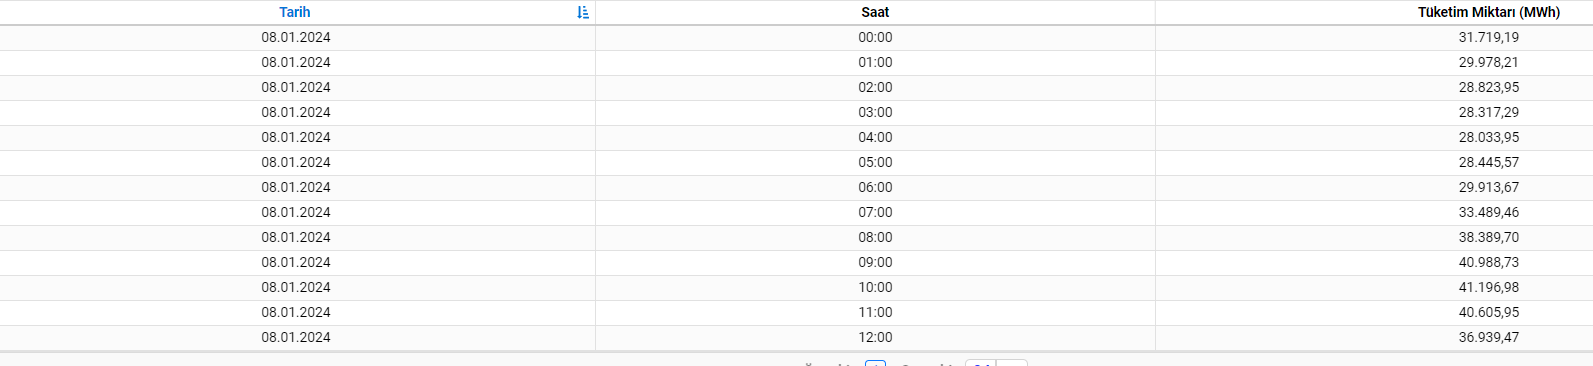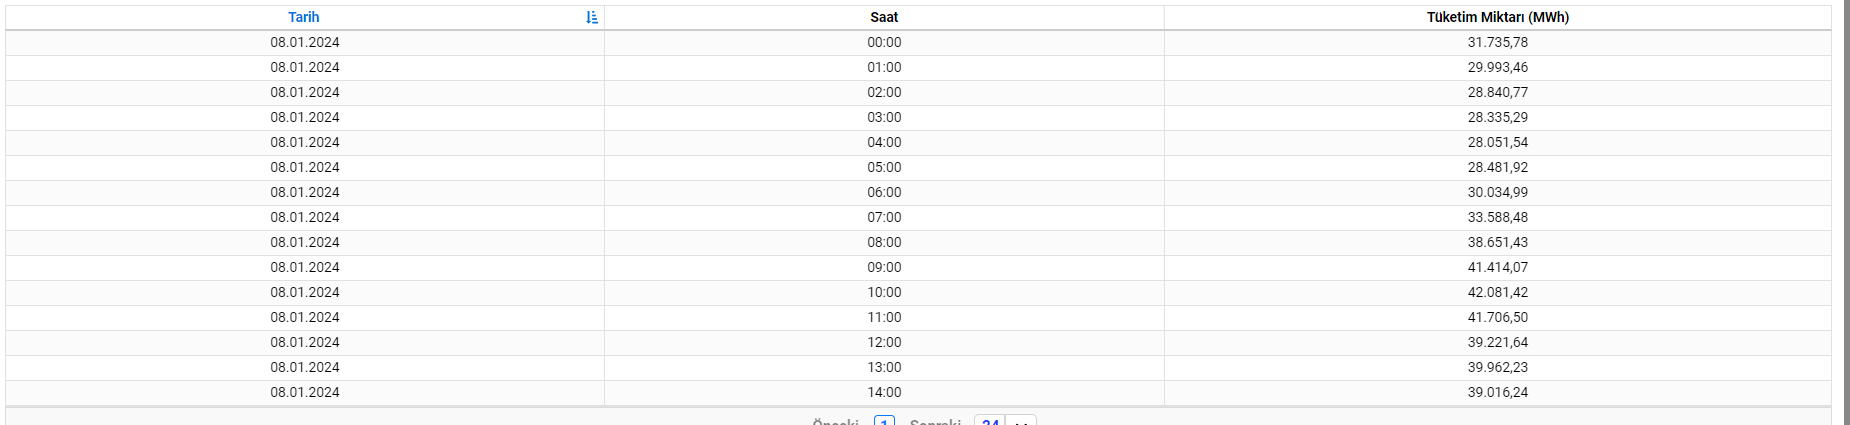)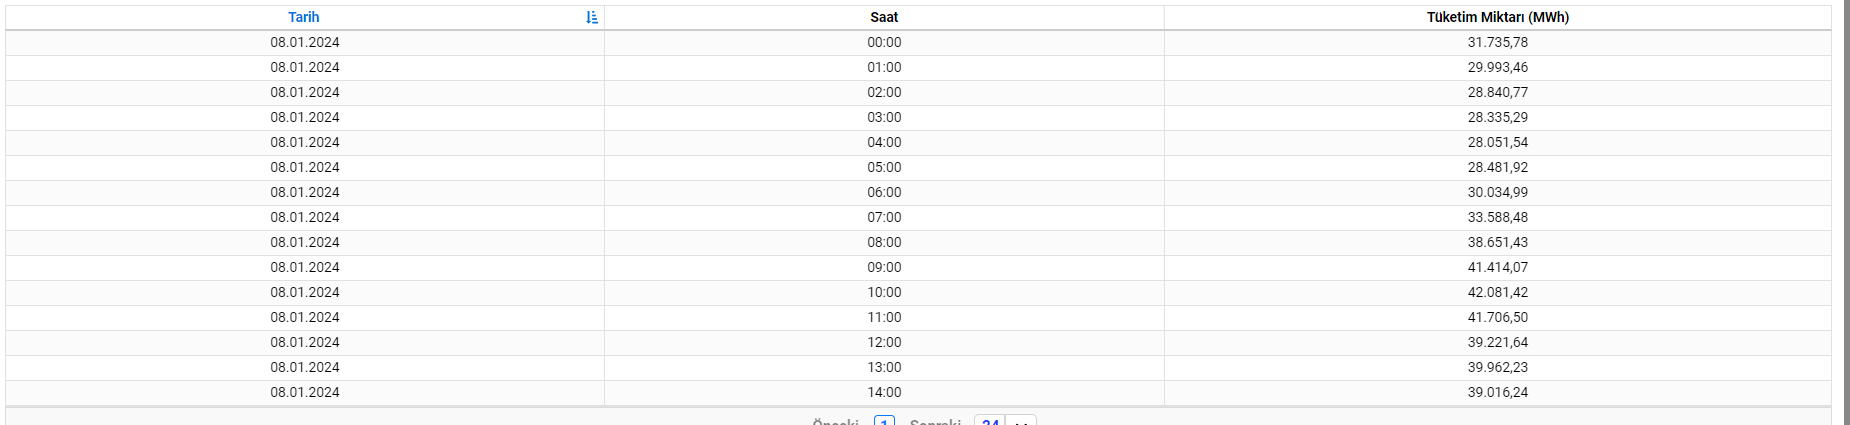